In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import tensorflow.contrib.learn as learn
from sklearn.metrics import classification_report, confusion_matrix, precision_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from datetime import datetime

# Load actors with score

In [4]:
actors = pd.read_csv('fomc_scorecard.csv', sep=";", index_col=3, header=0)
actors = actors[actors['Score'] != 0]

# Load articles

In [5]:
from pymongo import MongoClient

In [6]:
client = MongoClient('localhost', 27017)
fomc_collection = client.python_import.fomc_articles

In [7]:
fomc_articles = pd.DataFrame(list(fomc_collection.find()))
fomc_articles.set_index('_id', inplace=True)

# Merge articles and actors score

In [8]:
fomc_articles_scored = fomc_articles.merge(actors, left_on='ParticipantName', right_index=True)
fomc_articles_scored.head(2)

,ParticipantJobTitle,ParticipantLocation,ParticipantName,ParticipantTitleLastName,ParticipantUrl,RemarkDate,RemarkDescription,RemarkType,content,date,url,Name,Score,Shifted score
_id,,,,,,,,,,,,,,
58cab2973740f50f2c6fdccb,Pres.,Richmond,Jeffrey Lacker,Pres. Lacker,/fomcspeak/jeffrey-lacker,"Dec. 03, 2013",Lacker Testifies on Bankruptcy and Financial I...,Testimony,Good morning. I am honored to speak to the Sub...,2013-12-03 00:00:00,https://www.richmondfed.org/press_room/speeche...,Jeffrey M. Lacker,2,4
58cab29e3740f50f2c6fdcce,Pres.,Richmond,Jeffrey Lacker,Pres. Lacker,/fomcspeak/jeffrey-lacker,"Apr. 18, 2013 (8:06 AM ET)",Fed's Lacker Would End QE Now,Video Interview,Fed's Lacker Would End QE Now\n\t\t\t\t\n In a...,2013-04-18 08:06:00,http://video.cnbc.com/gallery/?video=3000162414,Jeffrey M. Lacker,2,4


# Number of articles in each score class

In [9]:
fomc_articles_scored.groupby('Score')['url'].count()

Score
-2    148
-1    168
 1    150
 2     72
Name: url, dtype: int64

# Create train data and test data

In [10]:
train_data = fomc_articles_scored[fomc_articles_scored['date'] < datetime(2016, 6, 1)]
test_data = fomc_articles_scored[fomc_articles_scored['date'] >= datetime(2016, 6, 1)]

In [11]:
def mapping(val):
    if val == -2:
        return 0
    elif val == -1:
        return 1
    elif val == 1:
        return 2
    elif val == 2:
        return 3

In [12]:
X_train = train_data['content']
y_train = train_data['Score'].map(mapping)
X_test = test_data['content']
y_test = test_data['Score'].map(mapping)

# Tf-Idf and DNN model

In [13]:
vectorizer = CountVectorizer(stop_words='english', max_df=0.4, min_df=3, ngram_range=(1,3))
transformer = TfidfTransformer(norm='l2')
vectorizer.fit(X_train)
vect_data = vectorizer.transform(X_train)
transformer.fit(vect_data)
X_train_tfidf = transformer.transform(vect_data).toarray()

In [14]:
def vectorize_and_transform(data):
    vect_data = vectorizer.transform(data)
    return (transformer.transform(vect_data)).toarray()

In [15]:
feature_columns = learn.infer_real_valued_columns_from_input(X_train_tfidf)
classifier = learn.DNNClassifier(n_classes=4, hidden_units=[50,70,10], feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_task_id': 0, '_master': '', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B47180CB70>, '_save_checkpoints_steps': None, '_environment': 'local', '_num_ps_replicas': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_save_checkpoints_secs': 600, '_tf_random_seed': None}


In [16]:
classifier.fit(X_train_tfidf, y_train.as_matrix(), batch_size=20, steps=400)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scal

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\neural\AppData\Local\Temp\tmp2l45_w6b\model.ckpt.
INFO:tensorflow:loss = 1.38649, step = 1
INFO:tensorflow:global_step/sec: 32.7516
INFO:tensorflow:loss = 1.0672, step = 101
INFO:tensorflow:global_step/sec: 33.3401
INFO:tensorflow:loss = 0.188173, step = 201
INFO:tensorflow:global_step/sec: 34.4072
INFO:tensorflow:loss = 0.0747317, step = 301
INFO:tensorflow:Saving checkpoints for 400 into C:\Users\neural\AppData\Local\Temp\tmp2l45_w6b\model.ckpt.
INFO:tensorflow:Loss for final step: 0.00933274.


DNNClassifier(params={'activation_fn': <function relu at 0x000001B46E6EA840>, 'embedding_lr_multipliers': None, 'feature_columns': (_RealValuedColumn(column_name='', dimension=48726, default_value=None, dtype=tf.float64, normalizer=None),), 'gradient_clip_norm': None, 'input_layer_min_slice_size': None, 'hidden_units': [50, 70, 10], 'optimizer': None, 'dropout': None, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x000001B471930CC0>})

### Fitting the model

In [17]:
X_test_tfidf = vectorize_and_transform(X_test)
predicted = list(classifier.predict(X_test_tfidf, as_iterable=True))

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


#### Confusion matrix
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [18]:
cm = confusion_matrix(y_test, predicted)

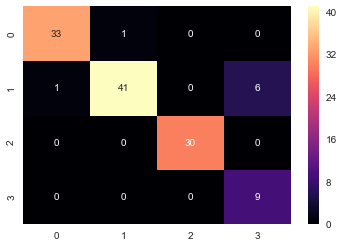

In [19]:
sns.heatmap(cm, cmap='magma', annot=True)

In [20]:
cr = classification_report(y_test, predicted)
print(cr)

             precision    recall  f1-score   support

          0       0.97      0.97      0.97        34
          1       0.98      0.85      0.91        48
          2       1.00      1.00      1.00        30
          3       0.60      1.00      0.75         9

avg / total       0.95      0.93      0.94       121

